 Import libraries and read the data:



In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset
data_path = '/content/ITC.csv'
df = pd.read_csv(data_path)

# Display the first few rows of the dataframe
print(df.head())


         Date        Open        High         Low       Close   Adj Close  \
0  2019-05-29  288.799988  291.700012  287.600006  288.100006  239.825165   
1  2019-05-30  289.000000  291.049988  288.299988  288.649994  240.282959   
2  2019-05-31  289.350006  291.500000  277.450012  278.549988  231.875366   
3  2019-06-03  281.399994  281.500000  275.299988  278.549988  231.875366   
4  2019-06-04  279.250000  282.149994  278.799988  279.250000  232.458038   

     Volume  
0   7255516  
1   8656311  
2  26281811  
3  19569620  
4  13850737  


Preprocess the data:

In [27]:
# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Use only the 'Open' column for prediction
data = df[['Open']]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]


Prepare the data for the LSTM model:

In [28]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60  # Number of previous days to consider for predicting the next day
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


Build and train the LSTM model:

In [29]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)


Epoch 1/100
29/29 [==============================] - 7s 90ms/step - loss: 0.0177
Epoch 2/100
29/29 [==============================] - 2s 79ms/step - loss: 0.0016
Epoch 3/100
29/29 [==============================] - 2s 83ms/step - loss: 8.5961e-04
Epoch 4/100
29/29 [==============================] - 2s 52ms/step - loss: 8.2091e-04
Epoch 5/100
29/29 [==============================] - 2s 54ms/step - loss: 8.0014e-04
Epoch 6/100
29/29 [==============================] - 2s 55ms/step - loss: 7.7832e-04
Epoch 7/100
29/29 [==============================] - 1s 49ms/step - loss: 7.5741e-04
Epoch 8/100
29/29 [==============================] - 2s 79ms/step - loss: 7.3048e-04
Epoch 9/100
29/29 [==============================] - 2s 68ms/step - loss: 7.0810e-04
Epoch 10/100
29/29 [==============================] - 2s 57ms/step - loss: 7.7676e-04
Epoch 11/100
29/29 [==============================] - 1s 48ms/step - loss: 6.9847e-04
Epoch 12/100
29/29 [==============================] - 1s 47ms/step - lo

Make predictions and visualize the results:

6/6 [==============================] - 0s 18ms/step


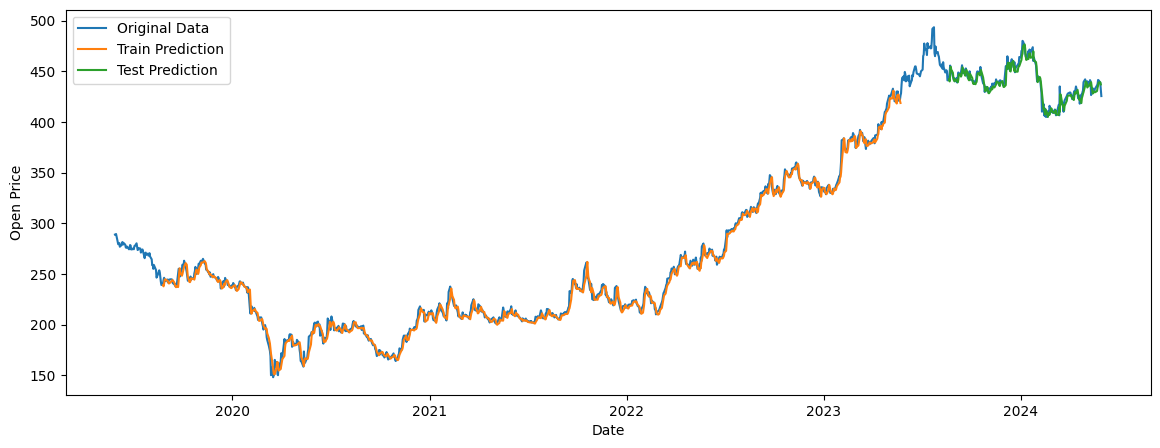

In [30]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Visualize the results
plt.figure(figsize=(14, 5))
plt.plot(df.index, data['Open'], label='Original Data')

# Creating a DataFrame to visualize train and test predictions separately
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict)+time_step, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(time_step*2)+1:len(scaled_data)-1, :] = test_predict

# Plotting
plt.plot(df.index, train_plot, label='Train Prediction')
plt.plot(df.index, test_plot, label='Test Prediction')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()
